In [1]:
import json
import pathlib

import cv2
import numpy as np
import matplotlib.pyplot as plt

from statistics import mode
from typing import Any, Callable

from src import video, feed
from src.display import showarray
from src.processing import ImageMatcher, Homographer, BoardMapper
from src.processing import analyzers, detectors, features, calc
from src.monopoly.elements import FieldIndex, deserialize_families, deserialize_fields

In [2]:
board_image = cv2.imread("data/images/board.jpg")

In [3]:
CARD_RATIO = 8.5 / 5.5

def filter_contours(contours: list[np.ndarray]) -> list[np.ndarray]:
    
    return [
        contour 
        for contour in contours
        if calc.is_min_area_in_bounds_and_good_edges_ratio(contour, 10_000, 25_000, CARD_RATIO)
    ]

In [4]:
class RectDrawingEntry:
    def __init__(self, name: str, color: tuple[int, int, int]) -> None:
        self.name = name
        self.color = color
        self.rect: Any = None

    def draw_rect(self, frame: np.ndarray) -> np.ndarray:
        if self.rect is None:
            return frame

        x, y, w, h = self.rect
        return cv2.rectangle(frame, (x, y), (x + w, y + h), self.color, 2)


class PointsDrawingEntry(RectDrawingEntry):
    def draw_rect(self, frame: np.ndarray) -> np.ndarray:
        if self.rect is None:
            return frame

        return cv2.polylines(frame, [np.int32(self.rect)], True, self.color, 2)


class RectDrawingAnalyzer(analyzers.Analyzer):
    def __init__(self, drawing_entries: list[RectDrawingEntry]) -> None:
        self.drawing_entries = drawing_entries
        
    def analyze_raw(self, frame: np.ndarray, **kwargs) -> None:
        for entry in self.drawing_entries:
            entry.rect = kwargs.get(entry.name)

    def mutate_frame(self, frame: np.ndarray) -> np.ndarray:
        for entry in self.drawing_entries:
            frame = entry.draw_rect(frame)
        return frame

In [5]:
class ContextHistorySaver:
    def __init__(self):
        self.history = {}

    def __call__(self, context: dict) -> None:
        for key in context:
            if key not in self.history:
                self.history[key] = []
            self.history[key].append(context[key])


context_history_saver = ContextHistorySaver()

In [6]:
board_drawing_entry = PointsDrawingEntry("board_points", (255, 255, 0))
dice_area_drawing_entry = RectDrawingEntry("dice_area_rect", (0, 255, 255))

rect_analyzer = RectDrawingAnalyzer(
    [board_drawing_entry, dice_area_drawing_entry]
)

white_piece_analyzer = analyzers.WhitePieceAnalyzer(
    piece_detector=detectors.get_white_piece_detector(),
    binarizer=features.get_clear_inverted_edges, 
    threaded=True
)
black_piece_analyzer = analyzers.BlackPieceAnalyzer(
    piece_detector=detectors.get_black_piece_detector(),
    binarizer=features.get_clear_inverted_edges, 
    threaded=True
)

dots_analyzer = analyzers.DotsAnalyzer(blob_detector=detectors.get_dots_detector(), threaded=True)
cards_analyzer = analyzers.CardsAnalyzer(
    edge_detector=features.get_threshold_edges,
    contour_filter=filter_contours,
    threaded=True
)

live_feed = feed.LiveFrameProcessor("feed", 800, 400)

used_analyzers = [rect_analyzer, white_piece_analyzer, black_piece_analyzer, dots_analyzer, cards_analyzer]

In [144]:
with video.VideoHandler("data/recordings/Easy_2.mp4") as vh:
    first_frame = vh.get_frame(0)
    image_matcher = ImageMatcher(first_frame, board_image)
    matches = image_matcher.get_matches()
    homographer = Homographer(image_matcher.kp_ref, image_matcher.kp_match, matches)
    inv_homography, _ = homographer.get_inverse_homography()
    dst_rect = features.get_board_min_rect_from_homography(inv_homography, board_image)
    additonal_context = dict(board_points=cv2.boxPoints(dst_rect), dice_area_rect=features.find_dice_throwing_rect(first_frame))
    vh.go_through_video(live_feed, used_analyzers, additional_context=additonal_context, context_processor=context_history_saver)

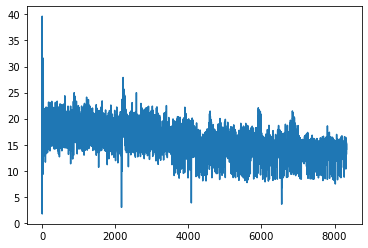

In [145]:
plt.plot(context_history_saver.history["fps"])
plt.show()

In [146]:
board_mapper = BoardMapper(homographer.get_homography()[0], max(board_image.shape))

serialized_families = json.loads(pathlib.Path("data/meta/families.json").read_text())
serialized_fields = json.loads(pathlib.Path("data/meta/fields.json").read_text())

families = {family.name: family for family in deserialize_families(serialized_families)}
fields = list(deserialize_fields(serialized_fields, families))
field_index = FieldIndex(fields)

In [147]:
board_mapper.map_point_to_field_position(*context_history_saver.history["black_pos"][20])


('bottom', 5)

In [148]:
def decode_position(field_index: FieldIndex, position: tuple[int, int] | None, board_mapper: BoardMapper, last_decoded: int | None = None):
    decoded_position = None
    if position is not None:
        section, index = board_mapper.map_point_to_field_position(*position)
        if section not in ["inside", "outside"]:
            field = field_index.get_by_place(section, index)
            if field is not None:
                decoded_position = field.id
    if decoded_position is None:
        decoded_position = last_decoded
    return decoded_position

def decode_positions(field_index: FieldIndex, positions: list[tuple[int, int] | None], board_mapper: BoardMapper):
    decoded_positions = []
    last_decoded = None
    for position in positions:
        decoded_position = decode_position(field_index, position, board_mapper, last_decoded)
        if decoded_position is not None:
            decoded_positions.append(decoded_position)
        last_decoded = decoded_position
    return decoded_positions

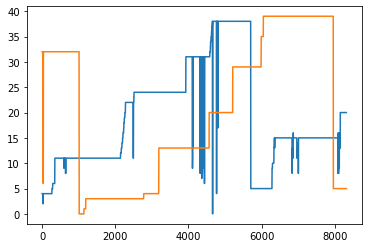

In [149]:
black_decoded = decode_positions(field_index, context_history_saver.history["black_pos"], board_mapper)
white_decoded = decode_positions(field_index, context_history_saver.history["white_pos"], board_mapper)

plt.plot(black_decoded)
plt.plot(white_decoded)
plt.show()

In [150]:
def denoise_series_middle(series: list[int], window_size: int = 5) -> list[int]:
    return [mode(series[i - window_size:i + window_size]) for i in range(window_size, len(series) - window_size)]

def denoise_series_left(series: list[int], window_size: int = 5) -> list[int]:
    return [mode(series[i - window_size:i]) for i in range(window_size, len(series) - window_size)]

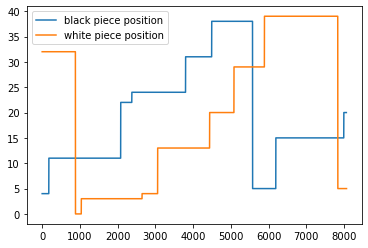

In [151]:
denoised_black = denoise_series_middle(black_decoded, window_size=130)
denoised_white = denoise_series_middle(white_decoded, window_size=130)

plt.plot(denoised_black, label="black piece position")
plt.plot(denoised_white, label="white piece position")
plt.legend()
plt.show()

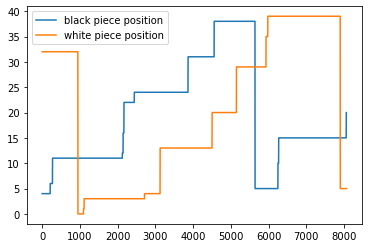

In [152]:
denoised_black = denoise_series_left(black_decoded, window_size=130)
denoised_white = denoise_series_left(white_decoded, window_size=130)

plt.plot(denoised_black, label="black piece position")
plt.plot(denoised_white, label="white piece position")
plt.legend()
plt.show()

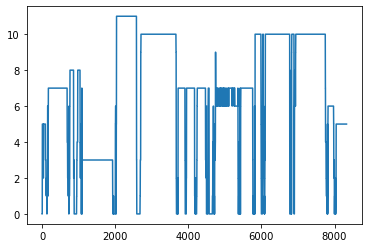

In [153]:
dice_result = [len(points) for points in context_history_saver.history["dice_dots"]]
plt.plot(dice_result)
plt.show()

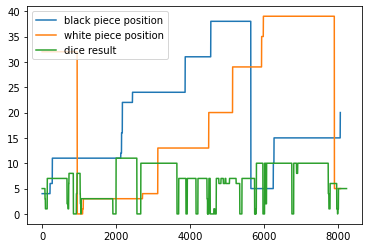

In [154]:
plt.plot(denoised_black, label="black piece position")
plt.plot(denoised_white, label="white piece position")
plt.plot(denoise_series_left(dice_result, window_size=50), label="dice result")
plt.legend()
plt.show()

In [167]:
average = [kp.pt for kp in context_history_saver.history["dice_dots"][3]]
average = np.average(average, axis=0)

dice_pos_avg_x = [np.average([kp.pt[0] for kp in dots]) if dots else 0 for dots in context_history_saver.history["dice_dots"]]
dice_pos_avg_y = [np.average([kp.pt[1] for kp in dots]) if dots else 0 for dots in context_history_saver.history["dice_dots"]]

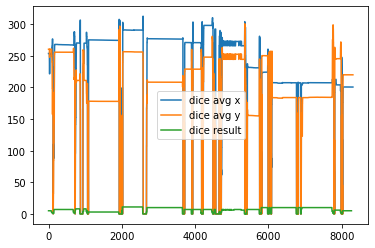

In [172]:
plt.plot(denoise_series_left(dice_pos_avg_x, 10), label="dice avg x")
plt.plot(denoise_series_left(dice_pos_avg_y, 10), label="dice avg y")
plt.plot(denoise_series_left(dice_result, 30), label="dice result")
plt.legend()
plt.show()


In [155]:
cards = context_history_saver.history["cards"]
height, width = first_frame.shape[:2]

black_cards = []
white_cards = []
for frame_cards in cards:
    frame_black_cards = []
    frame_white_cards = []
    for card in frame_cards:
        if card[0] < width / 2:
            frame_black_cards.append(card)
        else:
            frame_white_cards.append(card)
    black_cards.append(frame_black_cards)
    white_cards.append(frame_white_cards)

In [156]:
black_cards_count = [len(cards) for cards in black_cards]
white_cards_count = [len(cards) for cards in white_cards]

denoised_black_cards_count = denoise_series_left(black_cards_count, window_size=250)
denoised_white_cards_count = denoise_series_left(white_cards_count, window_size=250)

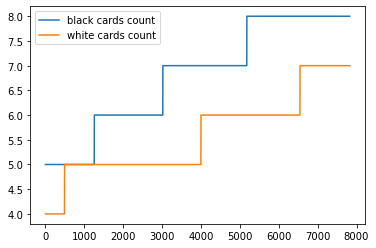

In [157]:
plt.plot(denoised_black_cards_count, label="black cards count")
plt.plot(denoised_white_cards_count, label="white cards count")
plt.legend()
plt.show()

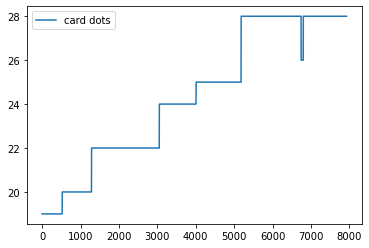

In [158]:
card_dots = [len(points) for points in context_history_saver.history["card_dots"]]
denoised_card_dots = denoise_series_left(card_dots, window_size=200)
plt.plot(denoised_card_dots, label="card dots")
plt.legend()
plt.show()

In [243]:
class ContextReader:
    def __init__(self, name: str, window_length: int, read_from_context: Callable[[dict], Any], value_mutator: Callable[[Any], Any] = lambda x: x):
        self.name = name
        self.window_length = window_length
        self.history = []
        self.read_from_context = read_from_context
        self.value_mutator = value_mutator

    def read(self, context: dict):
        self.history.append(self.read_from_context(context))
        self.history = self.history[-self.window_length:]
    
    def get_value(self):
        return self.value_mutator(mode(self.history))

In [288]:
class EventDetector:
    def __init__(self, tracked_readers: list[ContextReader]):
        self.tracked_readers = {reader.name: reader for reader in tracked_readers}

    def detect(self) -> bool:
        raise NotImplementedError

    def get_message(self) -> str:
        raise NotImplementedError

class DiceEventDetector(EventDetector):
    def __init__(self, tracked_readers: list[ContextReader]):
        super().__init__(tracked_readers)
        self.last_throw = None
        self.last_pos = None
        self.last_non_zero_pos = None
        self.cooldown = -1

    def detect(self) -> bool:
        self.cooldown -= 1
        dice_dots_reader = self.tracked_readers["dice_dots"]
        dice_pos_x_reader = self.tracked_readers["dice_pos_x"]
        last_pos = self.last_pos
        cur_pos = dice_pos_x_reader.get_value()
        if last_pos == 0 and cur_pos != 0 and (self.last_non_zero_pos is None or np.abs(cur_pos - self.last_non_zero_pos) > 1):
            self.cooldown = 25
        if cur_pos != 0:
            self.last_non_zero_pos = cur_pos
        self.last_pos = cur_pos

        self.last_throw = dice_dots_reader.get_value()
        return self.cooldown == 0

    def get_message(self) -> str:
        if self.last_throw is None or self.last_throw < 2:
            self.cooldown = 3
            return ""
        print("DICE EVENT")
        return f"Dice throw detected - rolled {self.last_throw}"

class CardEventDetector(EventDetector):
    def __init__(self, tracked_readers: list[ContextReader], player: str):
        super().__init__(tracked_readers)
        self.cards = 0
        self.player = player
        self.property = ""
    
    def detect(self) -> bool:
        detected_cards = self.tracked_readers[f"{self.player}_cards"].get_value()
        if detected_cards > self.cards:
            self.cards = detected_cards
            self.property = self.tracked_readers[f"{self.player}_pos"].get_value()
            return True
        return False

    def get_message(self) -> str:
        print("PROPERTY EVENT")
        return f"{self.player.capitalize()} bought new property ({self.property})"


class MoveEventDetector(EventDetector):
    def __init__(self, tracked_readers: list[ContextReader], player: str):
        super().__init__(tracked_readers)
        self.player = player
        self.last_position = None

    def detect(self) -> bool:
        position = self.tracked_readers[f"{self.player}_pos"].get_value()
        if self.last_position is None:
            self.last_position = position
            return False
        if position != self.last_position:
            self.last_position = position
            return True
        return False

    def get_message(self) -> str:
        print("MOVE EVENT")
        msg = f"{self.player.capitalize()} moved to {self.last_position}"
        if self.last_position == "Go to Prison":
            msg += f" - {self.player.capitalize()} goes to prison"
        elif self.last_position == "Community Chest":
            msg += f" - {self.player.capitalize()} draws a community chest card"
        elif self.last_position == "Chance":
            msg += f" - {self.player.capitalize()} draws a chance card"
        return msg

In [289]:
class EventsAnalyzer(analyzers.Analyzer):
    def __init__(self, context_readers: list[ContextReader], event_detectors: list[EventDetector]):
        self.context_readers = context_readers
        self.event_detectors = event_detectors
        self.stat_font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        self.message_font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        self.message_lifetime = 200
        self.messages = []

    def analyze_raw(self, frame: np.ndarray, **context: dict) -> None:
        filtered_messages = []
        for message, frame_number in self.messages:
            if frame_number + self.message_lifetime > context["frame_number"]:
                filtered_messages.append((message, frame_number))
        self.messages = filtered_messages
        for event_context_reader in self.context_readers:
            event_context_reader.read(context)
        for event_detector in self.event_detectors:
            if event_detector.detect():
                self.messages.append((event_detector.get_message(), context["frame_number"]))
    
    def mutate_frame(self, frame: np.ndarray) -> np.ndarray:
        frame = cv2.rectangle(frame, (frame.shape[1] - 400, frame.shape[0] - 500), (frame.shape[1], frame.shape[0]), (0, 0, 0), -1)
        for i, event_context_reader in enumerate(self.context_readers):
            cv2.putText(frame, f"{event_context_reader.name}: {event_context_reader.get_value()}", (frame.shape[1] - 350, frame.shape[0] - 450 + 50 * i), self.stat_font, 1, (255, 255, 255), 2)
        for i, (message, frame_number) in enumerate(self.messages):
            cv2.putText(frame, message, (20, frame.shape[0]//2 - 200 + 50 * (i + len(self.context_readers))), self.message_font, 1, (0, 0, 0), 7)
            cv2.putText(frame, message, (20, frame.shape[0]//2 - 200 + 50 * (i + len(self.context_readers))), self.message_font, 1, (255, 255, 255), 2)
        return frame

In [290]:
def field_id_to_name(field_id):
    if field_id is None:
        return "Searching..."
    field = field_index.get_by_id(field_id)
    if field is not None:
        return field.name
    return "Searching..."


In [291]:
del context_readers
del event_detectors

context_readers = [
    ContextReader("black_pos", 130, lambda context: decode_position(field_index, context["black_pos"], context["board_mapper"]), field_id_to_name),
    ContextReader("white_pos", 130, lambda context: decode_position(field_index, context["white_pos"], context["board_mapper"]), field_id_to_name),
    ContextReader("dice_dots", 80, lambda context: len(context["dice_dots"])), 
    ContextReader("dice_pos_x", 30, lambda context: np.average([kp.pt[0] for kp in context["dice_dots"]]) if context["dice_dots"] else 0 ), 
    ContextReader("dice_pos_y", 30, lambda context: np.average([kp.pt[1] for kp in context["dice_dots"]]) if context["dice_dots"] else 0 ), 
    ContextReader("black_cards", 130, lambda context: len([card for card in context["cards"] if card[0] >= width / 2])),
    ContextReader("white_cards", 130, lambda context: len([card for card in context["cards"] if card[0] < width / 2])),
    ContextReader("card_dots", 200, lambda context: len(context["card_dots"])),
]

event_detectors = [
    DiceEventDetector(context_readers),
    CardEventDetector(context_readers, "black"),
    CardEventDetector(context_readers, "white"),
    MoveEventDetector(context_readers, "black"),
    MoveEventDetector(context_readers, "white"),
]

events_analyzer = EventsAnalyzer(context_readers=context_readers, event_detectors=event_detectors) # type: ignore
used_analyzers_with_events = [*used_analyzers, events_analyzer]

with video.VideoHandler("data/recordings/Easy_3.mp4") as vh:
    first_frame = vh.get_frame(0)
    image_matcher = ImageMatcher(first_frame, board_image)
    matches = image_matcher.get_matches()
    homographer = Homographer(image_matcher.kp_ref, image_matcher.kp_match, matches)
    inv_homography, _ = homographer.get_inverse_homography(method=cv2.RHO)
    homography, _ = homographer.get_homography()
    board_mapper = BoardMapper(homography, max(board_image.shape))
    dst_rect = features.get_board_min_rect_from_homography(inv_homography, board_image)
    board_points = cv2.boxPoints(dst_rect)
    additonal_context = dict(board_points=board_points, dice_area_rect=features.find_dice_throwing_rect(first_frame), board_mapper=board_mapper)
    vh.go_through_video(live_feed, used_analyzers_with_events, additional_context=additonal_context)

PROPERTY EVENT
MOVE EVENT
DICE EVENT
MOVE EVENT
MOVE EVENT
DICE EVENT
MOVE EVENT
DICE EVENT
DICE EVENT
MOVE EVENT
MOVE EVENT
PROPERTY EVENT
DICE EVENT
MOVE EVENT
PROPERTY EVENT
DICE EVENT
MOVE EVENT
MOVE EVENT
PROPERTY EVENT
